<a href="https://colab.research.google.com/github/RITabayuni/Skripsi_Perbandingan_K-Prototypes_Agglomerative-Gower/blob/main/Implementation_Rahimi_Illong_Tabayuni_225150707111046.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***LIBRARY PREPARATION***

In [2]:
!pip install kmodes openpyxl

In [3]:
!pip install gower kmodes openpyxl

In [4]:
from google.colab import drive, files
import glob, os, pandas as pd
import numpy as np
import math
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import gower
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram

**VALIDASI PERHITUNGAN MANUAL K-PROTOTYPES**

In [5]:
# Upload file Excel (Colab)
from google.colab import files
uploaded = files.upload()  # PerhitunganManual-Skripsi.xlsx

filename = list(uploaded.keys())[0]
print("File yang dipakai:", filename)

# Load data sample dari Excel
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes

SHEET_NAME = "Sample"
df = pd.read_excel(filename, sheet_name=SHEET_NAME)

print("Jumlah baris sampel:", len(df))
print("Kolom yang terbaca:", df.columns.tolist())

# Penentuan kolom numerik & kategorikal
num_cols = ["year", "month"]
cat_cols = ["system", "type", "redefacement", "attacker_group", "location_group"]

X = df[num_cols + cat_cols].copy()

for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce")
for c in cat_cols:
    X[c] = X[c].astype(str)

# handle missing values
for c in num_cols:
    X[c] = X[c].fillna(X[c].median())
for c in cat_cols:
    X[c] = X[c].replace(["nan", "None", "NONE", "NULL"], np.nan).fillna("Unknown")

cat_idx = [X.columns.get_loc(c) for c in cat_cols]
X_np = X.to_numpy()

# Menjalankan K-Prototypes
kproto = KPrototypes(
    n_clusters=2,      # samakan dengan jumlah klaster pada perhitungan manual
    init="Huang",
    n_init=1,
    random_state=42,
    verbose=0
)

labels = kproto.fit_predict(X_np, categorical=cat_idx)

# simpan label hasil library
df["cluster_lib"] = labels + 1

print(df["cluster_lib"].value_counts().sort_index())
df[num_cols + cat_cols + ["cluster_lib"]].head(10)


Saving PerhitunganManual-Skripsi.xlsx to PerhitunganManual-Skripsi.xlsx
File yang dipakai: PerhitunganManual-Skripsi.xlsx
Jumlah baris sampel: 15
Kolom yang terbaca: ['add_date', 'attacker', 'system', 'type', 'redefacement', 'location', 'attacker_group', 'location_group', 'year', 'month']
cluster_lib
1    6
2    9
Name: count, dtype: int64


,year,month,system,type,redefacement,attacker_group,location_group,cluster_lib
0,2023,1,Linux,regular,no,SABUNMANDI CYBER TEAM,United States,1
1,2023,2,FreeBSD,regular,no,/Rayzky_,United States,1
2,2023,3,Linux,regular,no,Indonesia Attacker,Indonesia,2
3,2023,4,Win 2000,mass,no,Other,Germany,2
4,2023,5,Linux,regular,yes,Mr. BDKR28,Other,2
5,2024,1,Linux,regular,no,Cyb3r_Drag0nz_Team,Other,1
6,2024,2,Win 2016,regular,yes,Other,United States,1
7,2024,3,Unknown,regular,no,Other,United States,2
8,2024,4,Linux,regular,yes,Other,Indonesia,2
9,2024,5,FreeBSD,regular,no,KingSkrupellos,United States,2


**KLASTERISASI MENGGUNAKAN K-PROTOTYPES**

Mounted at /content/drive
Proses K = 2
Proses K = 3
Proses K = 4
Proses K = 5
Proses K = 6
Proses K = 7
Proses K = 8
Proses K = 9


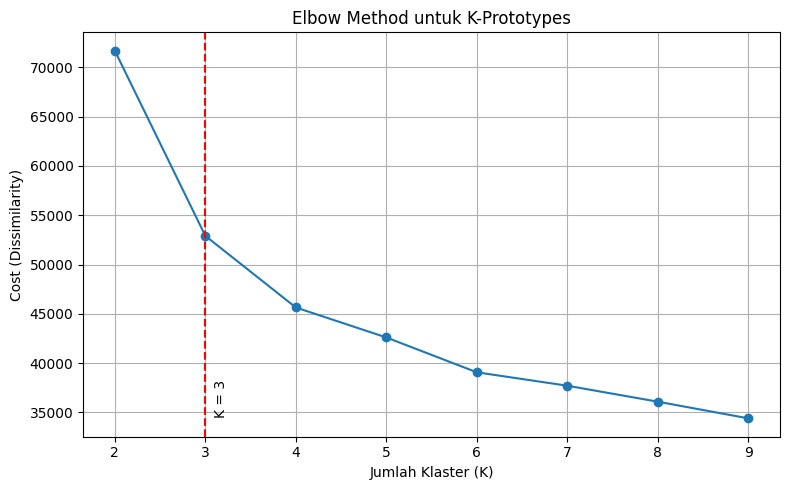

In [ ]:
# Penentuan Jumlah Klaster dengan Elbow Method
drive.mount('/content/drive')
csv_path = "/content/drive/MyDrive/"

df_full = pd.read_csv(csv_path)

# load data
NUM_COLS = ["year", "month"]
CAT_COLS = ["system", "type", "redefacement", "attacker", "location"]

X_full = df_full[NUM_COLS + CAT_COLS].copy()

# pastikan tipe data
for c in NUM_COLS:
    X_full[c] = pd.to_numeric(X_full[c], errors="coerce")
for c in CAT_COLS:
    X_full[c] = X_full[c].astype(str)

# handle missing
for c in NUM_COLS:
    X_full[c] = X_full[c].fillna(X_full[c].median())
for c in CAT_COLS:
    X_full[c] = X_full[c].fillna("Unknown")

cat_idx_full = [X_full.columns.get_loc(c) for c in CAT_COLS]
X_full_np = X_full.to_numpy()

# rentang K
K_RANGE = range(2, 10)
costs = []

for k in K_RANGE:
    print(f"Proses K = {k}")
    model = KPrototypes(
        n_clusters=k,
        init="Huang",
        n_init=10,
        random_state=42,
        verbose=0
    )
    model.fit_predict(X_full_np, categorical=cat_idx_full)
    costs.append(model.cost_)

# visualisasi elbow
BEST_K = 3

plt.figure(figsize=(8, 5))
plt.plot(list(K_RANGE), costs, marker="o")
plt.xlabel("Jumlah Klaster (K)")
plt.ylabel("Cost (Dissimilarity)")
plt.title("Elbow Method untuk K-Prototypes")
plt.grid(True)

plt.axvline(x=BEST_K, linestyle="--", color="red")
plt.text(BEST_K + 0.1, min(costs), f"K = {BEST_K}", rotation=90, va="bottom")

plt.tight_layout()
plt.show()



In [ ]:
# Pelatihan Model Akhir K-Prototypes
from kmodes.kprototypes import KPrototypes

BEST_K = 3

kproto_final = KPrototypes(
    n_clusters=BEST_K,
    init="Huang",
    n_init=10,
    random_state=42,
    verbose=0
)

labels_final = kproto_final.fit_predict(
    X_full_np,
    categorical=cat_idx_full
)

# simpan label ke dataset
df_full["cluster_kproto"] = labels_final + 1

print("Distribusi cluster:")
print(df_full["cluster_kproto"].value_counts().sort_index())

df_full.head()


Distribusi cluster:
cluster_kproto
1    3829
2    5482
3    4845
Name: count, dtype: int64


,add_date,attacker,system,type,redefacement,location,year,month,cluster_kproto
0,1/8/2023 15:38,Stormexx,Linux,regular,no,Germany,2023,1,2
1,1/1/2023 14:44,F4st~03,Linux,regular,no,Japan,2023,1,2
2,1/4/2023 7:04,Mr. BDKR28,Linux,regular,no,Germany,2023,1,2
3,1/4/2023 18:19,UnM@SK,Linux,mass,yes,Indonesia,2023,1,2
4,1/5/2023 9:07,Team Anon Force,Linux,regular,no,India,2023,1,2


**VALIDASI PERHITUNGAN MANUAL AGGLOMERATIVE CLUSTERING BERBASIS GOWER DISTANCE**

In [6]:
# Validasi Manual - Agglomerative (Gower + Complete)
print("File yang dipakai:", filename)

# Load sample
SHEET_NAME = "Sample"
df = pd.read_excel(filename, sheet_name=SHEET_NAME)

NUM_COLS = ["year", "month"]
CAT_COLS = ["system", "type", "redefacement", "attacker_group", "location_group"]

X = df[NUM_COLS + CAT_COLS].copy()

for c in NUM_COLS:
    X[c] = pd.to_numeric(X[c], errors="coerce").fillna(X[c].median())
for c in CAT_COLS:
    X[c] = X[c].astype(str).replace(["nan", "None", "NONE", "NULL"], np.nan).fillna("Unknown")

# Gower matrix
gower_mat = gower.gower_matrix(X)
print("Shape Gower matrix:", gower_mat.shape)

# Linkage (complete)
condensed = squareform(gower_mat, checks=False)
Z = linkage(condensed, method="complete")
print("Linkage matrix (5 baris pertama):")
print(Z[:5])

# Rekap langkah merge
n = X.shape[0]
clusters = {i: [i + 1] for i in range(n)}
records = []

for step in range(Z.shape[0]):  # total n-1 langkah
    c1, c2, dist, size = Z[step]
    c1, c2 = int(c1), int(c2)

    members = sorted(clusters[c1] + clusters[c2])
    new_id = n + step

    clusters[new_id] = members
    del clusters[c1]
    del clusters[c2]

    records.append({
        "Langkah": step + 1,
        "Cluster Gabung": ",".join(map(str, members)),
        "Jarak Terdekat": dist,
        "Jumlah Cluster": len(clusters)
    })

merge_steps = pd.DataFrame(records)
merge_steps


File yang dipakai: PerhitunganManual-Skripsi.xlsx
Shape Gower matrix: (15, 15)
Linkage matrix (5 baris pertama):
[[ 5.         10.          0.2142861   2.        ]
 [ 0.          1.          0.32142857  2.        ]
 [ 6.          7.          0.32142857  2.        ]
 [13.         14.          0.32142857  2.        ]
 [ 2.          8.          0.39285752  2.        ]]


,Langkah,Cluster Gabung,Jarak Terdekat,Jumlah Cluster
0,1,"6,11",0.214286,14
1,2,"1,2",0.321429,13
2,3,"7,8",0.321429,12
3,4,"14,15",0.321429,11
4,5,"3,9",0.392858,10
5,6,"10,13",0.428572,9
6,7,"3,5,9",0.500000,8
7,8,"7,8,10,13",0.535714,7
8,9,"6,11,12",0.535715,6
9,10,"1,2,6,11,12",0.607144,5


**KLASTERISASI MENGGUNAKAN AGGLOMERATIVE CLUSTERING BERBASIS GOWER DISTANCE**

Shape Gower matrix: (14156, 14156)
Index lonjakan terbesar: 14149
Threshold (cut height): 0.9155848026275635


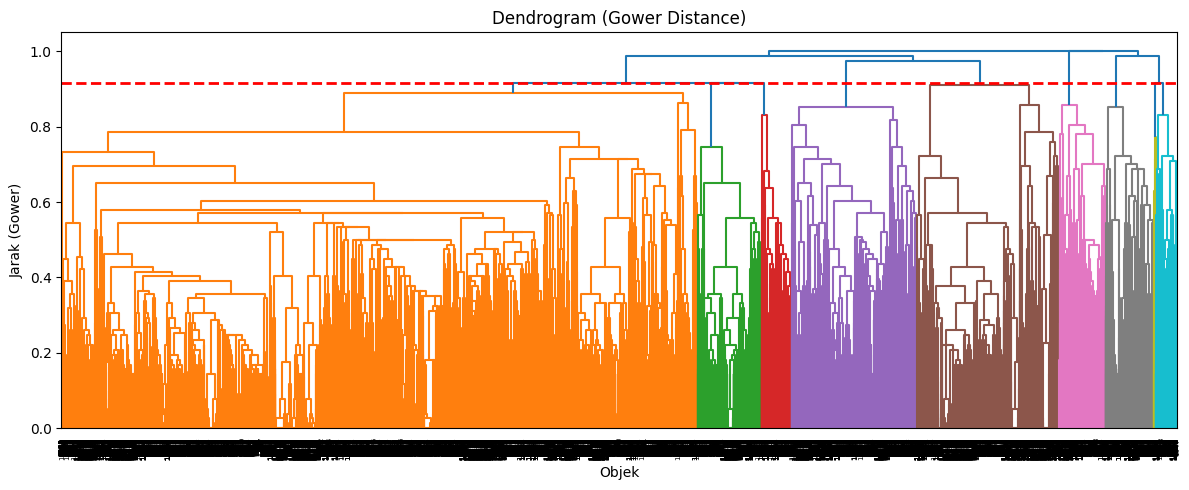

In [ ]:
# Penentuan Largest Gap - Agglomerative
NUM_COLS = ["year", "month"]
CAT_COLS = ["system", "type", "redefacement", "attacker", "location"]

X_full = df_full[NUM_COLS + CAT_COLS].copy()

for c in NUM_COLS:
    X_full[c] = pd.to_numeric(X_full[c], errors="coerce")
for c in CAT_COLS:
    X_full[c] = X_full[c].astype(str)

for c in NUM_COLS:
    X_full[c] = X_full[c].fillna(X_full[c].median())
for c in CAT_COLS:
    X_full[c] = X_full[c].fillna("Unknown")

# Gower distance matrix
gower_mat_full = gower.gower_matrix(X_full)
print("Shape Gower matrix:", gower_mat_full.shape)

# Linkage (complete)
condensed_full = squareform(gower_mat_full, checks=False)
Z_full = linkage(condensed_full, method="complete")

# Largest gap
distances = Z_full[:, 2]
diffs = np.diff(distances)

idx_max_gap = int(np.argmax(diffs))
threshold_auto = float(distances[idx_max_gap])

print("Index lonjakan terbesar:", idx_max_gap)
print("Threshold (cut height):", threshold_auto)

# Dendrogram
plt.figure(figsize=(12, 5))
dendrogram(Z_full, color_threshold=threshold_auto)
plt.axhline(y=threshold_auto, color="red", linestyle="--", linewidth=2)
plt.title("Dendrogram (Gower Distance)")
plt.xlabel("Objek")
plt.ylabel("Jarak (Gower)")
plt.tight_layout()
plt.show()


In [ ]:
# Bentuk label cluster berdasarkan threshold (distance cut)
labels_agglom = fcluster(Z_full, t=threshold_auto, criterion="distance")

# Simpan label ke dataset
df_full["cluster_agglom"] = labels_agglom

print("Sebaran cluster agglomerative:")
print(df_full["cluster_agglom"].value_counts().sort_index())

df_full.head()


Sebaran cluster agglomerative:
cluster_agglom
1    9269
2    1592
3    1803
4     586
5     614
6     292
Name: count, dtype: int64


,add_date,attacker,system,type,redefacement,location,year,month,cluster_kproto,cluster_agglom
0,1/8/2023 15:38,Stormexx,Linux,regular,no,Germany,2023,1,2,1
1,1/1/2023 14:44,F4st~03,Linux,regular,no,Japan,2023,1,2,1
2,1/4/2023 7:04,Mr. BDKR28,Linux,regular,no,Germany,2023,1,2,1
3,1/4/2023 18:19,UnM@SK,Linux,mass,yes,Indonesia,2023,1,2,6
4,1/5/2023 9:07,Team Anon Force,Linux,regular,no,India,2023,1,2,1


**EVALUASI MENGGUNAKAN SILHOUETTE SCORE**

In [ ]:
# A. Silhouette Score
# K-PROTOTYPES
def kproto_dissimilarity(X, gamma, cat_idx):
    n = X.shape[0]
    D = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            num_dist = 0
            cat_dist = 0
            for c in range(X.shape[1]):
                if c in cat_idx:
                    cat_dist += (X[i, c] != X[j, c])
                else:
                    num_dist += (float(X[i, c]) - float(X[j, c])) ** 2
            D[i, j] = num_dist + gamma * cat_dist
            D[j, i] = D[i, j]
    return D

gamma = kproto_final.gamma
D_kproto = kproto_dissimilarity(
    X_full_np.astype(object),
    gamma,
    cat_idx_full
)

silhouette_kproto = silhouette_score(
    D_kproto,
    df_full["cluster_kproto"],
    metric="precomputed"
)

print("Silhouette Score K-Prototypes:", silhouette_kproto)


# AGGLOMERATIVE
gower_D = np.array(gower_mat_full)

silhouette_agglom = silhouette_score(
    gower_D,
    df_full["cluster_agglom"],
    metric="precomputed"
)

print("Silhouette Score Agglomerative (Gower):", silhouette_agglom)


Silhouette Score K-Prototypes: 0.5520414500906795
Silhouette Score Agglomerative (Gower): 0.104549915


**EVALUASI MENGGUNAKAN DAVIES-BOOULDIN INDEX (DBI)**

In [ ]:
# B. Davies-Bouldin Index
def davies_bouldin_index(D, labels):
    labels = np.array(labels)
    clusters = np.unique(labels)
    k = len(clusters)

    # intra-cluster dispersion
    S = []
    for c in clusters:
        idx = np.where(labels == c)[0]
        if len(idx) <= 1:
            S.append(0)
        else:
            S.append(D[np.ix_(idx, idx)].mean())
    S = np.array(S)

    # inter-cluster distance
    M = np.zeros((k, k))
    for i, ci in enumerate(clusters):
        idx_i = np.where(labels == ci)[0]
        for j, cj in enumerate(clusters):
            if i == j:
                M[i, j] = np.inf
            else:
                idx_j = np.where(labels == cj)[0]
                M[i, j] = D[np.ix_(idx_i, idx_j)].mean()

    # DB index
    R = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            if i != j:
                R[i, j] = (S[i] + S[j]) / M[i, j]

    return R.max(axis=1).mean()


#K-PROTOTYPES
dbi_kproto = davies_bouldin_index(
    D_kproto,
    df_full["cluster_kproto"]
)
print("Davies-Bouldin Index K-Prototypes:", dbi_kproto)


# AGGLOMERATIVE
dbi_agglom = davies_bouldin_index(
    gower_D,
    df_full["cluster_agglom"]
)
print("Davies-Bouldin Index Agglomerative (Gower):", dbi_agglom)


Davies-Bouldin Index K-Prototypes: 0.6698784838410113
Davies-Bouldin Index Agglomerative (Gower): 1.7358444248212728


**VISUALISASI**

In [ ]:
# Helper: persiapan X untuk UMAP
def build_viz_matrix(df, num_cols, cat_cols):
    X_num = df[num_cols].copy()
    for c in num_cols:
        X_num[c] = pd.to_numeric(X_num[c], errors="coerce")
        X_num[c] = X_num[c].fillna(X_num[c].median())

    X_cat = df[cat_cols].copy()
    for c in cat_cols:
        X_cat[c] = X_cat[c].astype(str).fillna("Unknown")

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_cat_ohe = ohe.fit_transform(X_cat)

    X_viz = np.concatenate([X_num.values, X_cat_ohe], axis=1)
    return X_viz


# Profil cluster: numerik + top kategori
def cluster_profile_tables(df, cluster_col, num_cols, cat_cols, topn=10):
    dff = df.copy()
    dff[cluster_col] = dff[cluster_col].astype(int)

    # --- ringkasan numerik ---
    num_summary = (
        dff.groupby(cluster_col)[num_cols]
        .mean()
        .round(3)
        .sort_index()
        .reset_index()
        .rename(columns={cluster_col: "cluster"})
    )
    # ukuran cluster
    counts = (
        dff.groupby(cluster_col)
        .size()
        .rename("n")
        .reset_index()
        .rename(columns={cluster_col: "cluster"})
    )
    num_summary = counts.merge(num_summary, on="cluster", how="left")

    # ringkasan kategorikal (top-n proporsi per cluster)
    cat_tables = {}
    for col in cat_cols:
        top_global = (
            dff[col].astype(str).value_counts().head(topn).index.tolist()
        )
        tmp = dff[[cluster_col, col]].copy()
        tmp[col] = tmp[col].astype(str).where(tmp[col].astype(str).isin(top_global), "Other")

        ct = pd.crosstab(
            tmp[cluster_col].astype(int),
            tmp[col].astype(str),
            normalize="index"
        ).sort_index()

        ct = (ct * 100).round(2)
        ct.insert(0, "n", dff.groupby(cluster_col).size().sort_index().values)
        ct = ct.reset_index().rename(columns={cluster_col: "cluster"})
        cat_tables[col] = ct

    return num_summary, cat_tables


# UMAP plot per cluster + centroid
def plot_umap_clusters(df, cluster_col, num_cols, cat_cols, title="", random_state=42):
    dff = df.copy()
    dff[cluster_col] = dff[cluster_col].astype(int)

    X_viz = build_viz_matrix(dff, num_cols, cat_cols)

    reducer = umap.UMAP(random_state=random_state)
    X_umap = reducer.fit_transform(X_viz)

    labels = dff[cluster_col].values
    clusters = np.sort(np.unique(labels))

    plt.figure(figsize=(8, 6))

    for c in clusters:
        mask = labels == c
        plt.scatter(X_umap[mask, 0], X_umap[mask, 1], s=12, alpha=0.8, label=f"Cluster {c}")

    # centroid di ruang UMAP
    centroids = np.array([[X_umap[labels == c, 0].mean(), X_umap[labels == c, 1].mean()] for c in clusters])
    plt.scatter(centroids[:, 0], centroids[:, 1], s=220, marker="X", linewidths=1.5, label="Centroid")

    plt.title(title or f"UMAP Visualisasi Klaster ({cluster_col})")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Bar chart mean numerik per cluster
def plot_numeric_means_bar(df, cluster_col, num_cols, title_prefix="Mean", ylim_pad=0.10, title=""):
    dff = df.copy()
    dff[cluster_col] = dff[cluster_col].astype(int)

    means = dff.groupby(cluster_col)[num_cols].mean().sort_index()

    for col in num_cols:
        y = means[col].values
        x = means.index.astype(int).astype(str)

        plt.figure(figsize=(7, 4))
        bars = plt.bar(x, y)
        plt.title(f"{title_prefix} {col} per Klaster ({title})")
        plt.xlabel("Klaster")
        plt.ylabel(f"Mean {col}")
        plt.grid(True, axis="y", alpha=0.3)

        if len(y) > 0 and np.isfinite(y).all():
            plt.ylim(y.min() - ylim_pad, y.max() + ylim_pad)

        for b, val in zip(bars, y):
            plt.text(b.get_x() + b.get_width()/2, val, f"{val:.2f}", ha="center", va="bottom", fontsize=9)

        plt.tight_layout()
        plt.show()


# 4) Bar chart distribusi kategorikal (Top-N) per cluster
def plot_categorical_topn_per_cluster(df, cluster_col, cat_col, topn=10, title=""):
    dff = df.copy()
    dff[cluster_col] = dff[cluster_col].astype(int)

    top_global = dff[cat_col].astype(str).value_counts().head(topn).index.tolist()
    tmp = dff[[cluster_col, cat_col]].copy()
    tmp[cat_col] = tmp[cat_col].astype(str).where(tmp[cat_col].astype(str).isin(top_global), "Other")

    prop = pd.crosstab(tmp[cluster_col], tmp[cat_col], normalize="index").sort_index()

    # plot per cluster (bar bertumpuk horizontal biar jelas)
    clusters = prop.index.astype(int).tolist()
    categories = prop.columns.tolist()

    plt.figure(figsize=(10, 5))
    left = np.zeros(len(clusters))

    for cat in categories:
        vals = prop[cat].values
        plt.barh([str(c) for c in clusters], vals, left=left, label=str(cat))
        left += vals

    plt.xlabel("Proporsi")
    plt.ylabel("Klaster")
    plt.title(title or f"Distribusi {cat_col} per Klaster ({cluster_col}) (Top-{topn} + Other)")
    plt.grid(True, axis="x", alpha=0.3)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# 5) Plot Top-N attacker/location per cluster (subplots)
def plot_topn_horizontal_subplots(df, cluster_col, target_col, n=10, title="", max_cols=3):
    dff = df.copy()
    dff[cluster_col] = dff[cluster_col].astype(int)

    clusters = sorted(dff[cluster_col].unique())
    k = len(clusters)

    ncols = min(max_cols, k)
    nrows = int(np.ceil(k / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), squeeze=False)
    axes = axes.ravel()

    for i, c in enumerate(clusters):
        ax = axes[i]
        sub = dff[dff[cluster_col] == c]
        vc = (
            sub[target_col]
            .astype(str)
            .value_counts(normalize=True)
            .head(n)
            .sort_values()
        )
        ax.barh(vc.index, vc.values)
        ax.set_title(f"Klaster {c}")
        ax.set_xlabel("Proporsi")
        ax.grid(True, axis="x", alpha=0.3)

    for j in range(k, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title or f"Top-{n} {target_col} per Klaster ({cluster_col})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


== NUMERIC SUMMARY (K-Prototypes) ==


,cluster,n,year,month
0,1,3829,2023.960,5.949
1,2,5482,2023.663,2.623
2,3,4845,2024.010,9.516


== CATEGORICAL SUMMARY (K-Prototypes) ==

--- system ---


system,cluster,n,FreeBSD,Linux,MacOSX,OpenBSD,Other,Unknown,Win 2000,Win 2003,Win 2008,Win 2012,Win 2016
0,1,3829,13.82,74.07,0.26,0.29,0.10,9.19,0.44,0.24,0.10,0.52,0.97
1,2,5482,8.32,77.95,0.18,0.38,0.29,10.43,0.47,0.16,0.15,0.51,1.15
2,3,4845,13.58,74.26,0.25,0.21,0.12,8.96,0.52,0.23,0.27,0.47,1.14



--- type ---


type,cluster,n,mass,regular
0,1,3829,6.40,93.60
1,2,5482,9.45,90.55
2,3,4845,5.68,94.32



--- redefacement ---


redefacement,cluster,n,no,yes
0,1,3829,86.03,13.97
1,2,5482,84.20,15.80
2,3,4845,83.28,16.72



--- attacker ---


attacker,cluster,n,./KeyzNet,/Rayzky_,Hunter Bajwa,Imam,Indonesia Attacker,Mr. BDKR28,Other,Panataran,Simsimi,Team Anon Force,chinafans
0,1,3829,1.88,0.94,2.32,1.67,1.96,8.23,74.98,0.03,1.78,2.95,3.26
1,2,5482,3.23,2.70,0.55,6.71,1.68,2.83,73.84,0.13,2.61,1.66,4.07
2,3,4845,0.58,0.89,1.38,0.00,0.95,6.85,66.79,5.37,2.25,1.92,13.02



--- location ---


location,cluster,n,Brazil,Canada,France,Germany,India,Indonesia,Other,Russian Federation,Turkey,United Kingdom,United States
0,1,3829,1.62,1.83,3.19,7.65,2.22,2.59,24.16,2.04,1.41,4.52,48.79
1,2,5482,2.48,2.12,3.48,7.73,2.17,2.88,26.58,2.94,1.79,3.28,44.55
2,3,4845,1.92,2.11,3.45,8.98,1.96,2.39,24.99,1.94,1.59,4.36,46.32


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


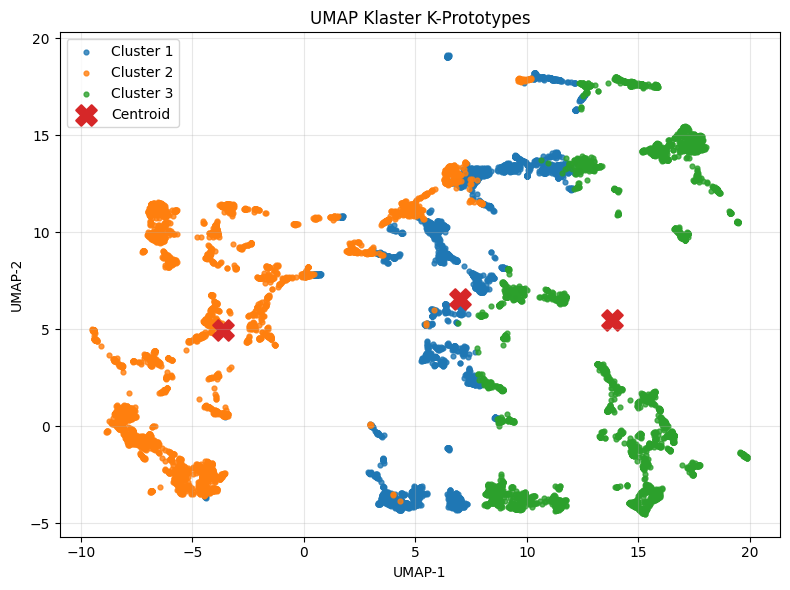

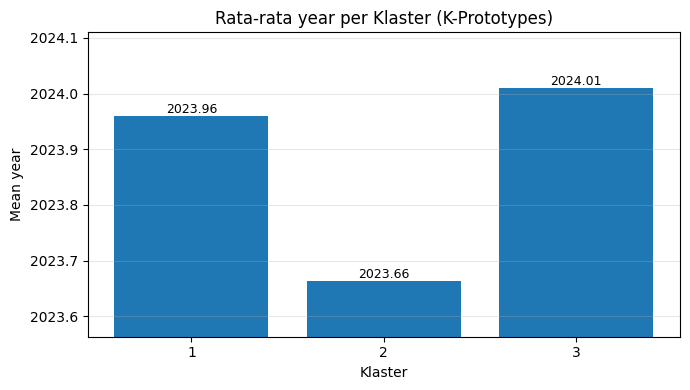

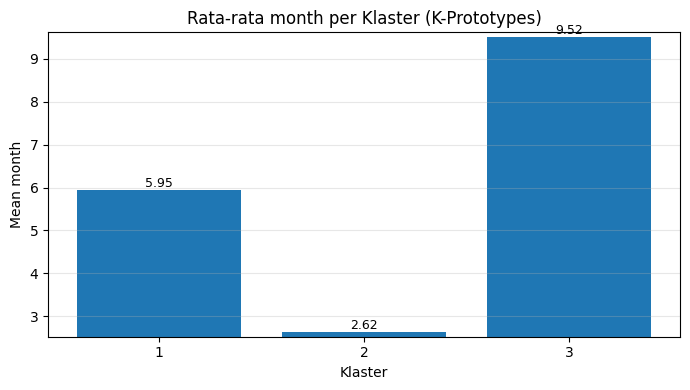

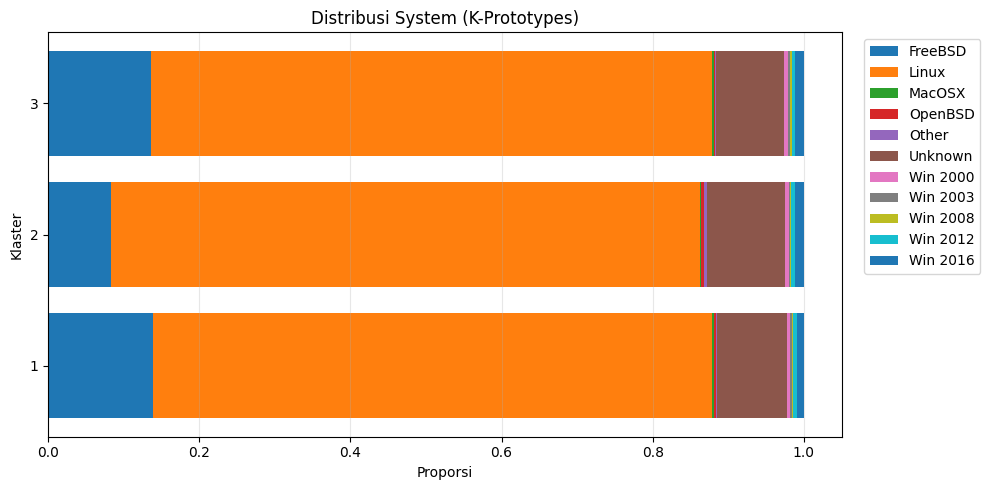

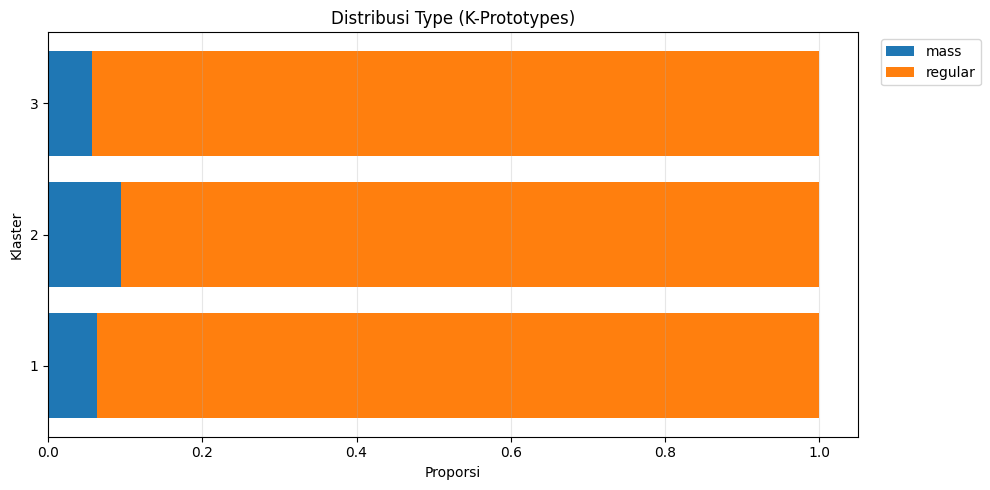

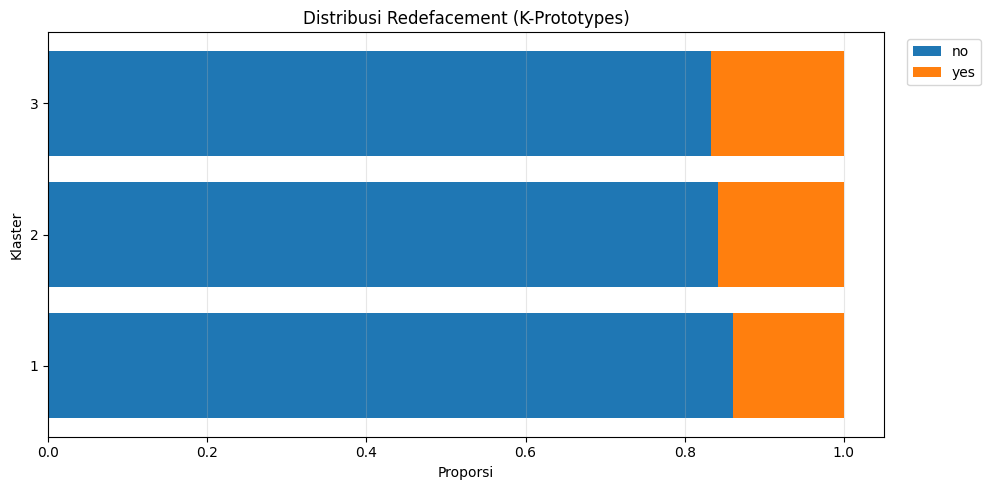

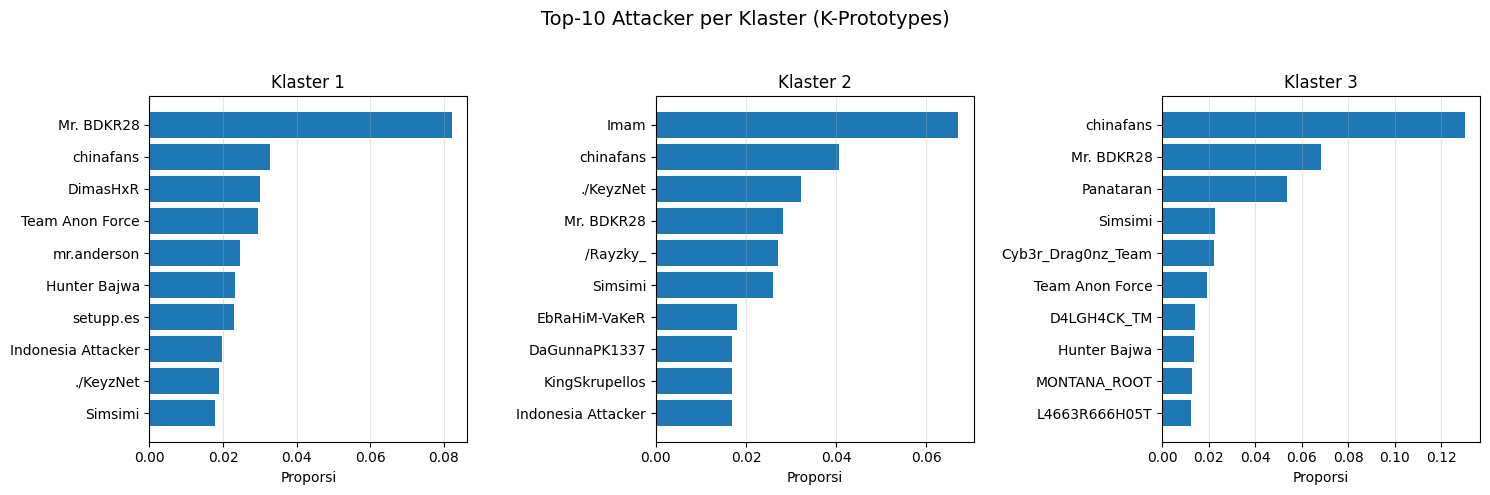

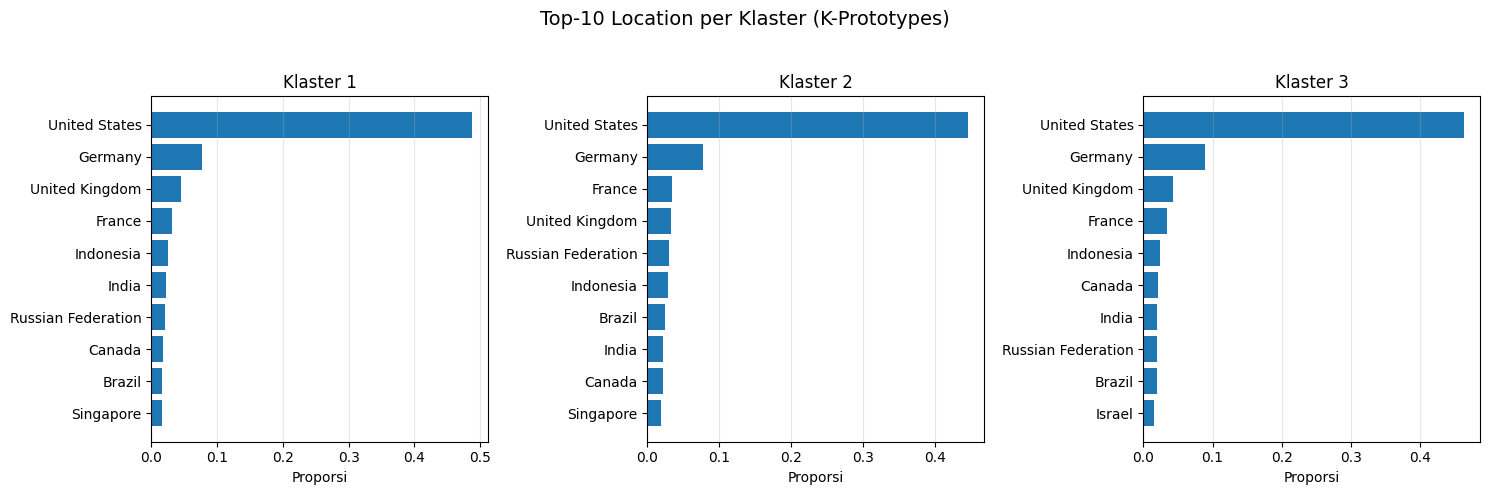

== NUMERIC SUMMARY (Agglomerative) ==


,cluster,n,year,month
0,1,9269,2023.793,5.832
1,2,1592,2023.833,6.033
2,3,1803,2024.392,6.553
3,4,586,2023.700,4.925
4,5,614,2023.664,5.432
5,6,292,2023.682,5.380


== CATEGORICAL SUMMARY (Agglomerative) ==

--- system ---


system,cluster,n,FreeBSD,Linux,MacOSX,OpenBSD,Other,Unknown,Win 2000,Win 2003,Win 2008,Win 2012,Win 2016
0,1,9269,1.20,84.94,0.27,0.24,0.14,11.49,0.57,0.19,0.13,0.42,0.41
1,2,1592,3.14,82.35,0.06,0.44,0.63,7.98,0.31,0.31,0.69,1.38,2.70
2,3,1803,77.09,19.30,0.28,0.50,0.00,2.55,0.00,0.00,0.00,0.00,0.28
3,4,586,13.14,60.24,0.17,0.68,0.51,20.48,1.71,0.00,0.34,1.37,1.37
4,5,614,0.00,90.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.93
5,6,292,5.14,92.12,0.00,0.00,0.00,0.00,0.00,2.05,0.00,0.68,0.00



--- type ---


type,cluster,n,mass,regular
0,1,9269,0.19,99.81
1,2,1592,0.57,99.43
2,3,1803,0.11,99.89
3,4,586,100.00,0.00
4,5,614,32.08,67.92
5,6,292,77.40,22.60



--- redefacement ---


redefacement,cluster,n,no,yes
0,1,9269,98.87,1.13
1,2,1592,0.38,99.62
2,3,1803,89.24,10.76
3,4,586,90.96,9.04
4,5,614,99.84,0.16
5,6,292,6.85,93.15



--- attacker ---


attacker,cluster,n,./KeyzNet,/Rayzky_,Hunter Bajwa,Imam,Indonesia Attacker,Mr. BDKR28,Other,Panataran,Simsimi,Team Anon Force,chinafans
0,1,9269,2.51,2.19,1.63,3.26,1.46,6.48,70.72,0.36,0.68,2.54,8.18
1,2,1592,1.13,0.38,1.13,4.77,4.15,3.39,62.56,5.84,12.19,1.70,2.76
2,3,1803,0.44,0.17,0.33,1.11,0.00,6.77,71.05,7.38,2.72,1.16,8.87
3,4,586,1.54,1.02,1.19,1.37,1.19,2.90,87.88,0.00,0.85,0.68,1.37
4,5,614,0.81,1.14,0.33,3.75,0.00,0.98,89.90,0.49,0.33,1.30,0.98
5,6,292,1.37,0.68,0.68,1.03,1.71,0.68,87.67,2.05,2.40,0.68,1.03



--- location ---


location,cluster,n,Brazil,Canada,France,Germany,India,Indonesia,Other,Russian Federation,Turkey,United Kingdom,United States
0,1,9269,1.92,2.42,3.17,9.67,1.94,2.10,22.88,2.22,1.68,4.90,47.09
1,2,1592,5.72,1.70,2.58,5.97,2.58,4.84,35.93,3.08,1.51,3.77,32.35
2,3,1803,0.22,0.55,4.77,4.55,0.55,3.55,10.15,1.94,0.39,0.28,73.04
3,4,586,1.02,3.07,7.34,8.02,8.02,1.71,39.59,3.58,2.05,4.27,21.33
4,5,614,1.14,0.49,1.14,2.61,1.79,0.49,60.26,1.95,0.49,1.14,28.50
5,6,292,1.71,2.05,3.08,5.48,3.42,8.22,39.38,3.42,9.25,4.45,19.52


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


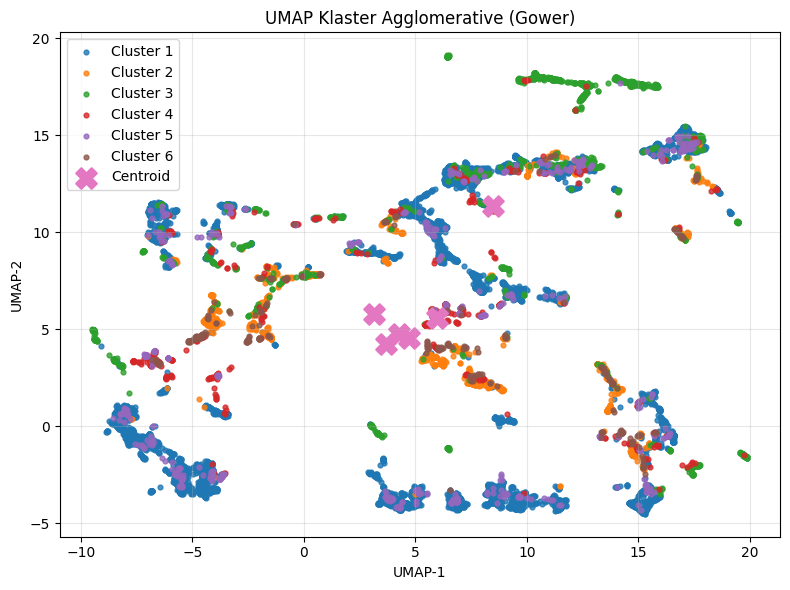

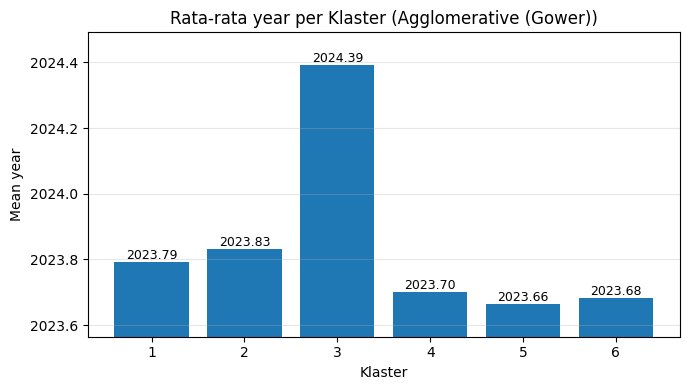

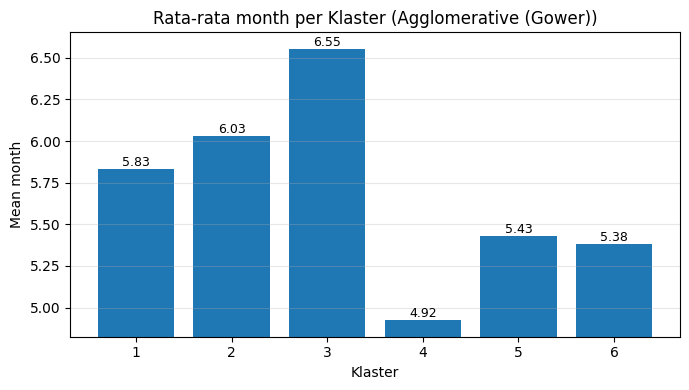

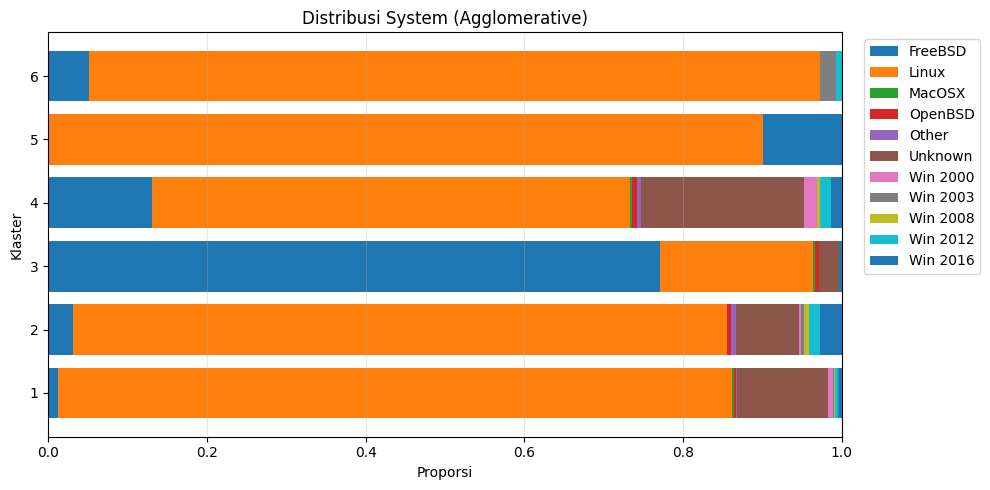

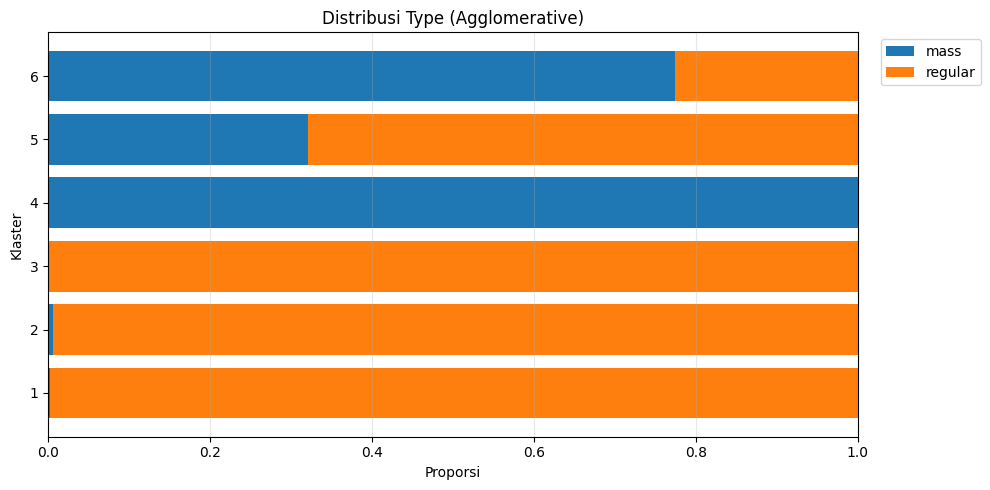

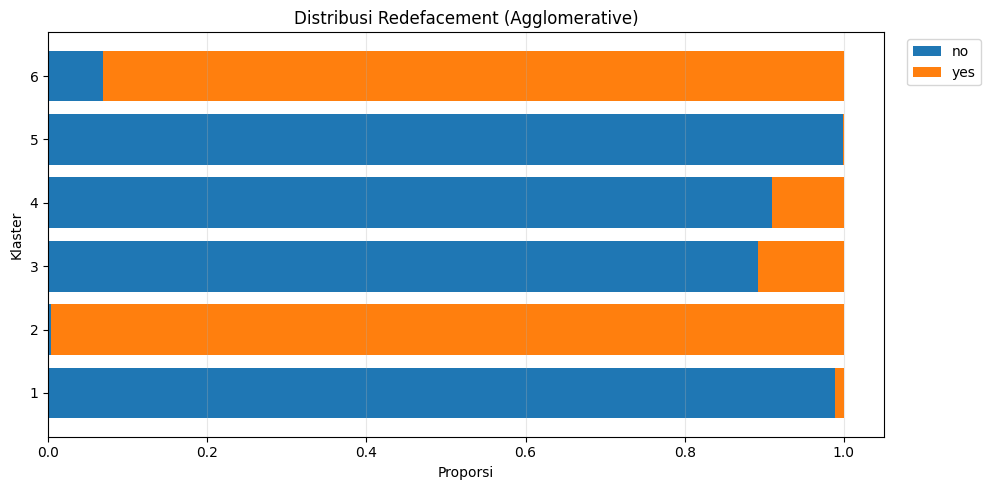

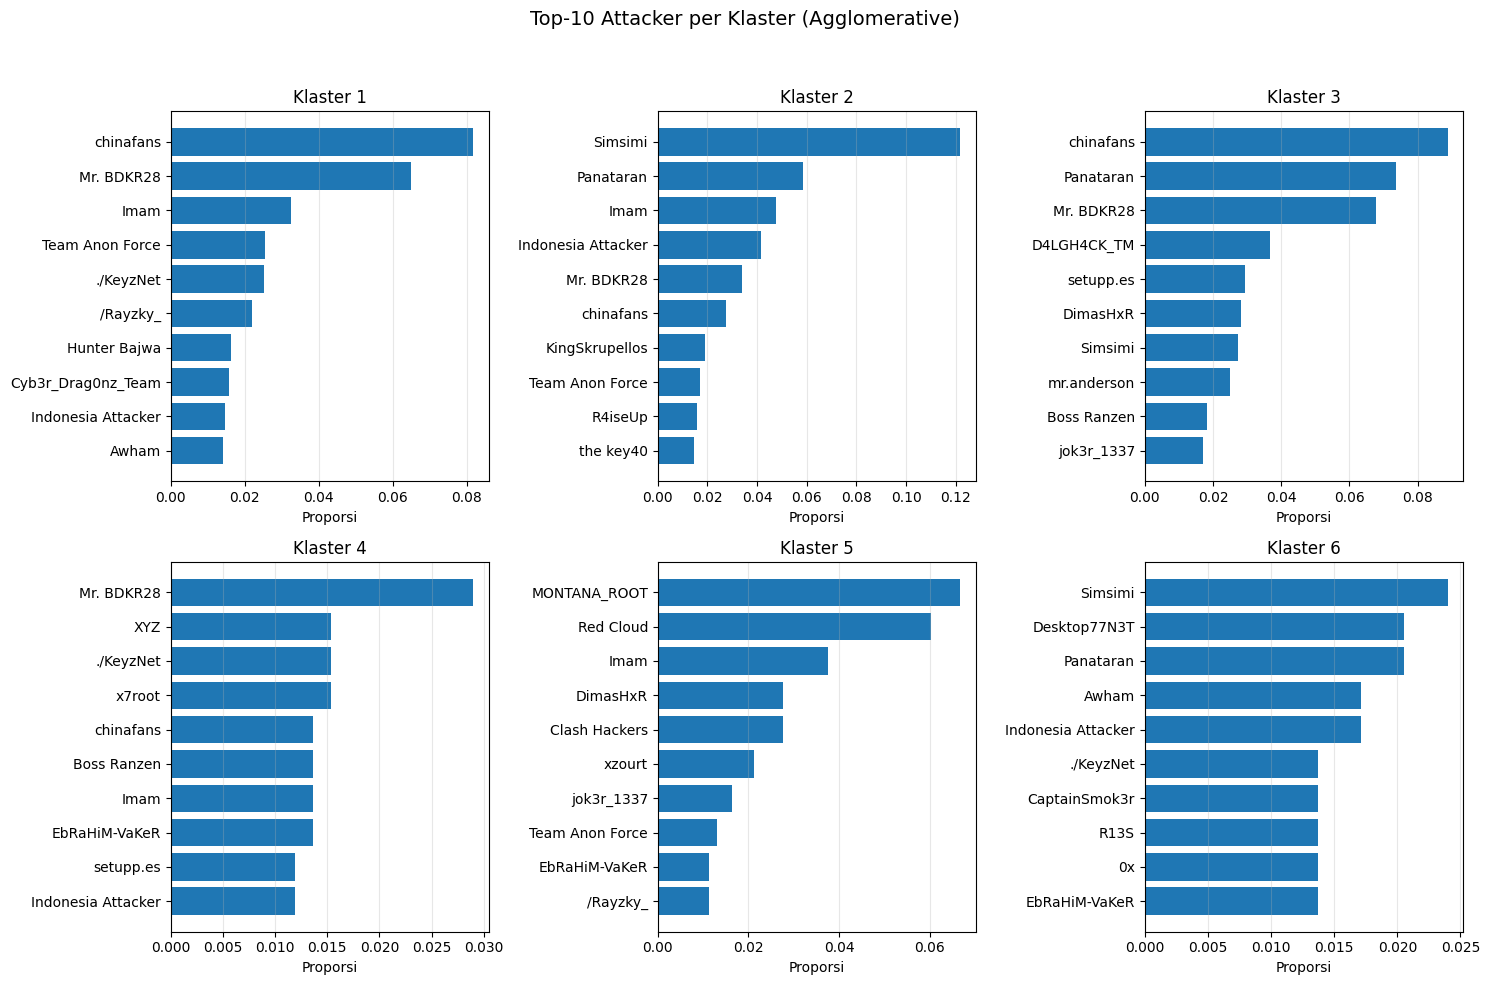

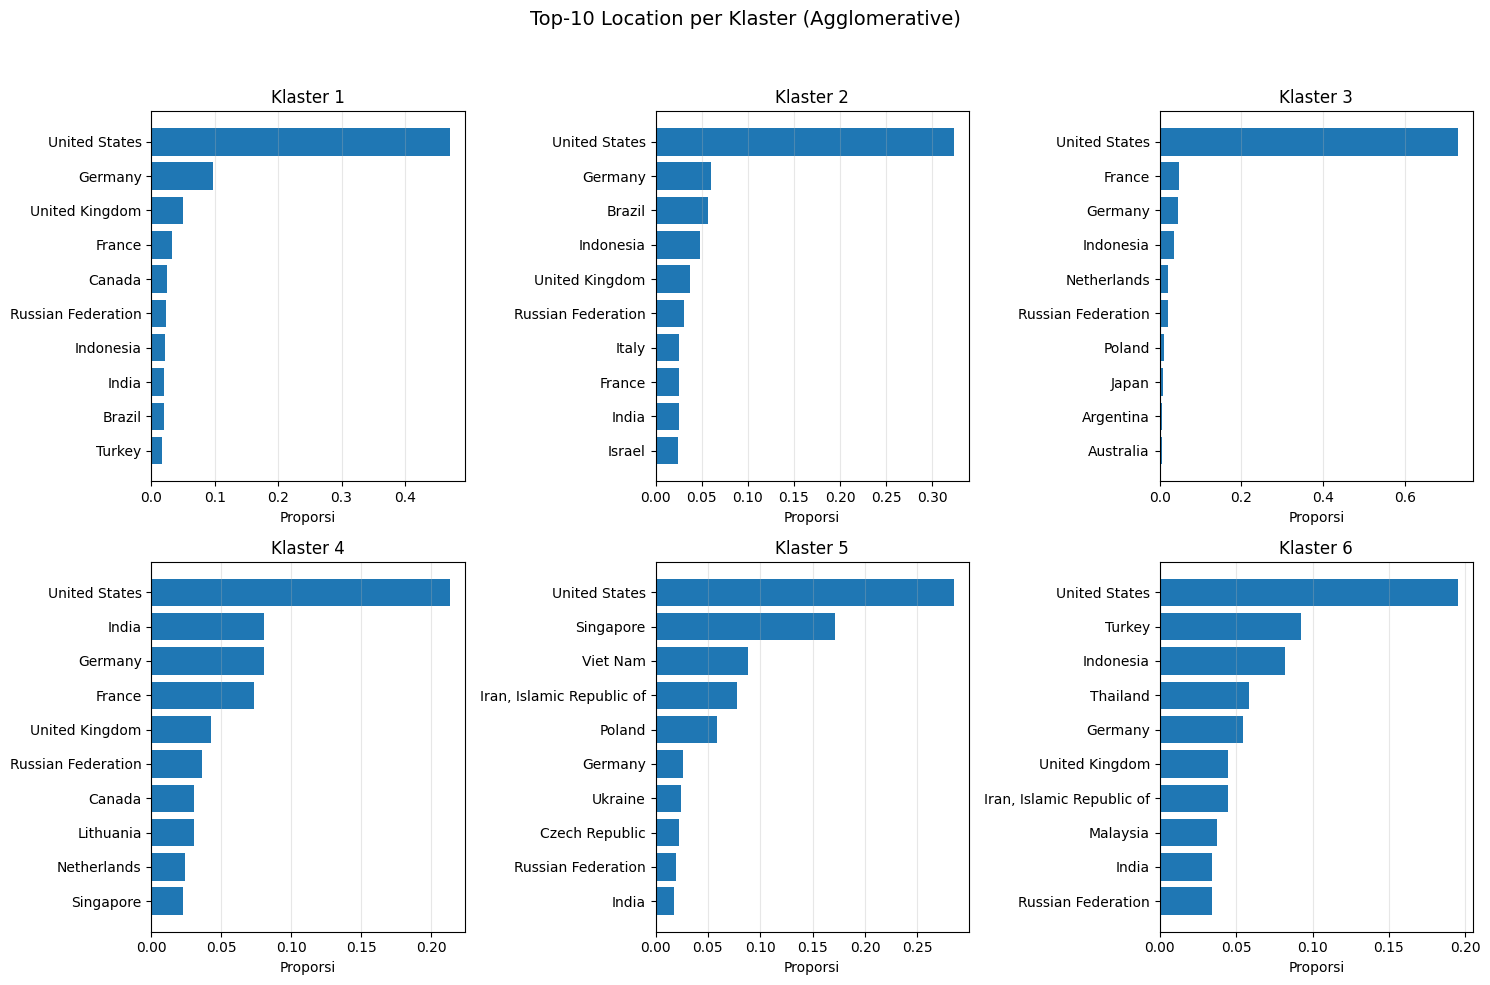

In [ ]:
# A) K-PROTOTYPES
num_kp, cat_kp = cluster_profile_tables(df_full, "cluster_kproto", num_cols, cat_cols, topn=10)
print("== NUMERIC SUMMARY (K-Prototypes) ==")
display(num_kp)

print("== CATEGORICAL SUMMARY (K-Prototypes) ==")
for col, tab in cat_kp.items():
    print(f"\n--- {col} ---")
    display(tab)

plot_umap_clusters(df_full, "cluster_kproto", num_cols, cat_cols, title="UMAP Klaster K-Prototypes")
plot_numeric_means_bar(df_full, "cluster_kproto", num_cols, title_prefix="Rata-rata", title="K-Prototypes")

plot_categorical_topn_per_cluster(df_full, "cluster_kproto", "system", topn=10, title="Distribusi System (K-Prototypes)")
plot_categorical_topn_per_cluster(df_full, "cluster_kproto", "type", topn=10, title="Distribusi Type (K-Prototypes)")
plot_categorical_topn_per_cluster(df_full, "cluster_kproto", "redefacement", topn=10, title="Distribusi Redefacement (K-Prototypes)")

plot_topn_horizontal_subplots(df_full, "cluster_kproto", "attacker", n=10, title="Top-10 Attacker per Klaster (K-Prototypes)")
plot_topn_horizontal_subplots(df_full, "cluster_kproto", "location", n=10, title="Top-10 Location per Klaster (K-Prototypes)")

# B) AGGLOMERATIVE
num_ag, cat_ag = cluster_profile_tables(df_full, "cluster_agglom", num_cols, cat_cols, topn=10)
print("== NUMERIC SUMMARY (Agglomerative) ==")
display(num_ag)

print("== CATEGORICAL SUMMARY (Agglomerative) ==")
for col, tab in cat_ag.items():
    print(f"\n--- {col} ---")
    display(tab)

plot_umap_clusters(df_full, "cluster_agglom", num_cols, cat_cols, title="UMAP Klaster Agglomerative (Gower)")
plot_numeric_means_bar(df_full, "cluster_agglom", num_cols, title_prefix="Rata-rata", title=f"Agglomerative (Gower)")

plot_categorical_topn_per_cluster(df_full, "cluster_agglom", "system", topn=10, title="Distribusi System (Agglomerative)")
plot_categorical_topn_per_cluster(df_full, "cluster_agglom", "type", topn=10, title="Distribusi Type (Agglomerative)")
plot_categorical_topn_per_cluster(df_full, "cluster_agglom", "redefacement", topn=10, title="Distribusi Redefacement (Agglomerative)")

plot_topn_horizontal_subplots(df_full, "cluster_agglom", "attacker", n=10, title="Top-10 Attacker per Klaster (Agglomerative)")
plot_topn_horizontal_subplots(df_full, "cluster_agglom", "location", n=10, title="Top-10 Location per Klaster (Agglomerative)")


**VISUALISASI AGGLOMERATIVE TANPA CENTROID**

In [ ]:
def plot_umap_clusters_no_center(df, cluster_col, num_cols, cat_cols,
                                 title="", random_state=42):
    dff = df.copy()
    dff[cluster_col] = dff[cluster_col].astype(int)

    X_viz = build_viz_matrix(dff, num_cols, cat_cols)

    reducer = umap.UMAP(random_state=random_state)
    X_umap = reducer.fit_transform(X_viz)

    labels = dff[cluster_col].values
    clusters = np.sort(np.unique(labels))

    plt.figure(figsize=(8, 6))

    for c in clusters:
        mask = labels == c
        plt.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            s=12,
            alpha=0.8,
            label=f"Cluster {c}"
        )

    plt.title(title or f"UMAP Visualisasi Klaster ({cluster_col})")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


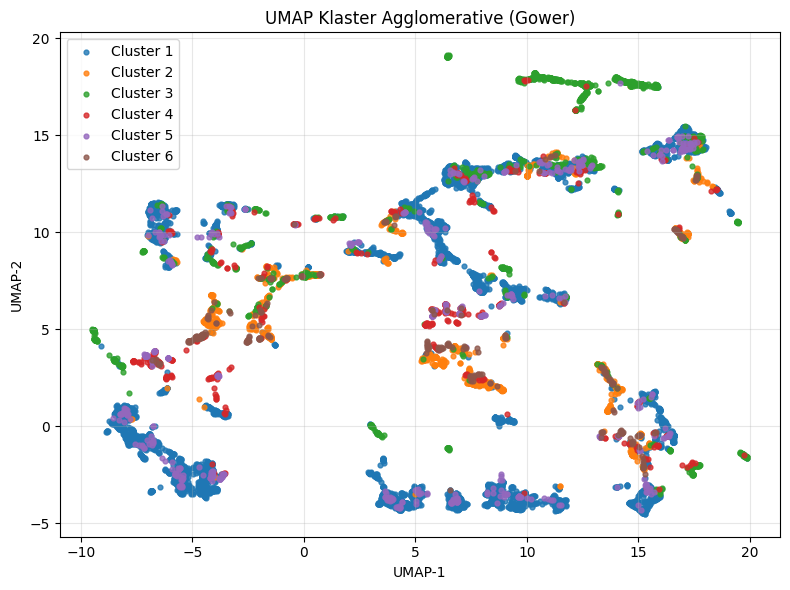

In [ ]:

plot_umap_clusters_no_center(
    df_full,
    "cluster_agglom",
    num_cols,
    cat_cols,
    title="UMAP Klaster Agglomerative (Gower)"
)
